We would like to know, qualitatively, what we would expect a fully random distrbution of Gd in AlN would look like, in terms of distribution of brightness. Here, we construct a randomly distributed supercell of AlGdN with a moderate amount of Gd, simulate its appearance in an ADF image, and (qualitatively) look at the distribution of brightnesses.

In [1]:
from pathlib import Path
from tkinter import Tk
from tkinter.filedialog import askopenfilename, asksaveasfilename

import abtem
import numpy as np
from copy import deepcopy
import ase.io as aio
from ase import Atoms
from ase.build import surface
from ase.visualize.plot import plot_atoms
from random import randint, seed, shuffle
from sys import maxsize

from sim_stem import simulate_stem, preview_stem_result

In [2]:
def tk_popover(save: bool = False, **kwargs):
    """Tk helper to ensure window appears on top."""
    root = Tk()
    root.iconify()
    root.attributes('-topmost', True)
    root.update()
    loc = None  # Default return if open fails; will likely cause an error when passed along
    try:
        if not save:
            loc = askopenfilename(parent=root, **kwargs)
        else:
            loc = asksaveasfilename(parent=root, **kwargs)

    finally:
        root.attributes('-topmost', False)
        root.destroy()
    return loc

# Simulation

In [3]:
# Setup abTEM / Dask parameters
abtem.config.set({"device":              "cpu",  # Configure abTEM to run on the GPU
                  "dask.lazy":           True,  # Setting to False can be useful for debugging
                  "dask.chunk-size":     "128 MB",  # 128 MB is the standard L3 cache size (per core)
                  "dask.chunk-size-gpu": "512 MB",  # Remember to leave space for overhead
                  "scheduler":           "threads",  # Threads or processes
                  "num_workers":         48  # Number of threads/processes to use for simulation (set to 1 for gpu)
                  })

<Axes: >

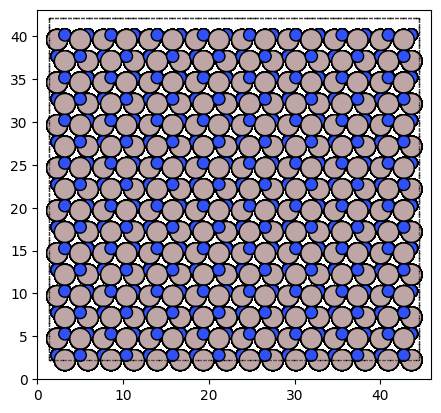

In [4]:
%matplotlib inline

# Open .cif & generate the potential
thickness: float = 200  # Angstrom; total thickness (z direction)
reps: int = 8  # How many repeats to have in x and y directions

cifpath = Path(tk_popover())  # Open AlN .cif file
uc = aio.read(cifpath)

# Get spanning vectors for the projected cell
# We do this with a temporary structure so we can set layers=1
c = np.linalg.norm(surface(uc, indices=(1, 1, 0), layers=1, periodic=True).cell[2])

surf = surface(uc, indices=(1, 1, 0), layers=int(thickness//c + 1), periodic=True)
slab = abtem.orthogonalize_cell(surf)
slab *= (reps, reps, 1)
plot_atoms(slab)

The following cells create a random distribution of Gd in the AlN supercell at a specified bulk composition. The cell is _not_ relaxed.

In [5]:
def randomize_chem(atoms: Atoms,
                   replacements: dict[str, dict[str, float]],
                   prseed: int = randint(0, maxsize))\
        -> Atoms:
    """Randomize the chemistry of an ASE ``Atoms`` object via to user-defined replacement rules.

    Parameters
    ----------
    atoms : Atoms
        Initial ASE ``Atoms`` object.  A changed copy of this object will be returned.
    replacements : Dict[str, Dict[str, float]]
        Replacement dictionary.  The keys should be the symbols of the initial elements to replace,
        and the values should themselves be dictionaries.  The value dicts should have keys which
        are the elements that will replace the corresponding initial element, and the values
        should be floats representing the fraction of the initial element to replace with the given
        element.  The sum of the floats must be <= 1 for each initial element.  For example:
            >>> {"Ba": {"Sr": 1},
            >>>  "Ti": {"Zr": 0.4,
            >>>         "Nb": 0.05}}
        would replace all Ba atoms in ``atoms`` with Sr, would randomly replace 40% of Ti atoms in
        ``atoms`` with Zr, and randomly replace 5% (of the initial amount of Ti) with Nb.
    prseed : int, optional
        Pseudo-random seed.  The default is to randomly choose a seed between 0 and sys.maxsize.

    Returns
    -------
    Atoms
        ASE ``Atoms`` object based on ``atoms``, but with the specified elemental replacements.
    """
    seed(prseed)
    new_atoms = deepcopy(atoms)

    # Add in NOP weights and then sanity check
    for elem, reps in replacements.items():
        if sum(reps.values()) < 1:  # Add in the "NOP weights" (chance to not replace) if needed
            reps[elem] = 1 - sum(reps.values())
        if sum(reps.values()) != 1:  # If this is ever False, we're likely to get garbage results
            raise RuntimeError(f"Sum of rep values ({sum(reps.values())}) not equal to 1!")

    symbols = new_atoms.get_chemical_symbols()
    uniques = list(set(symbols))  # Since set iteration order is not guaranteed, cast back to a list
    counts = dict(zip(uniques, [symbols.count(e) for e in uniques]))

    for elem, reps in replacements.items():
        elem_idxs = [idx for idx, sym in enumerate(symbols) if sym == elem]
        k = counts[elem]
        rep_counts = [round(k*w) for w in reps.values()]
        n = sum(rep_counts)

        while n != k:  # Counts may be off due to cumulative rounding error
            diffs = [c/k - w for w, c in zip(reps.values(), rep_counts)]
            if n < k:  # Since we have too few reps, we want to add one to the most negative diff
                mindex = diffs.index(min(diffs))
                rep_counts[mindex] = rep_counts[mindex] + 1
            elif n > k:  # Since we have too many reps, we want to remove one from the most positive diff
                maxdex = diffs.index(max(diffs))
                rep_counts[maxdex] = rep_counts[maxdex] - 1
            n = sum(rep_counts)

        rep_with = [x for sublist in  # Outer list comprehension to make sure we get a flat list
                    [[e]*c for e, c in zip(reps.keys(), rep_counts)]
                    for x in sublist]
        shuffle(rep_with)  # Now the only random step in this whole process is the shuffle

        for i in elem_idxs:
            symbols[i] = rep_with.pop()

    new_atoms.set_chemical_symbols(symbols)
    return new_atoms

<Axes: >

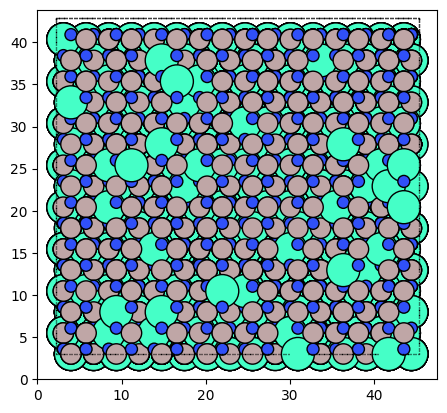

In [6]:
# Check 2 comps (13%, 17%), each with seeds: 554520389, 431247922, 120304979 (all from random.org)
substituted_slab = randomize_chem(slab, {"Al": {"Gd": 0.13}}, prseed=120304979)
plot_atoms(substituted_slab)

In [7]:
sigs = {"Al": 0.0748,  # Source: 10.1017/S0885715614000542
        "Gd": 0.1000,  # Source: rough est. from 10.1088/1742-6596/417/1/012049 & 10.1063/1.3658845
        "N":  0.0841}  # Source: 10.1017/S0885715614000542

fps = abtem.FrozenPhonons(substituted_slab,
                          num_configs=10,
                          sigmas=sigs,
                          ensemble_mean=True)

In [8]:
# Creating the potential takes couple minutes
potential = abtem.Potential(fps,
                            sampling=0.04,
                            projection="infinite",
                            parametrization="kirkland",
                            slice_thickness=2)
detector = abtem.detectors.AnnularDetector(46, 200)

[########################################] | 100% Completed | 913.98 ms


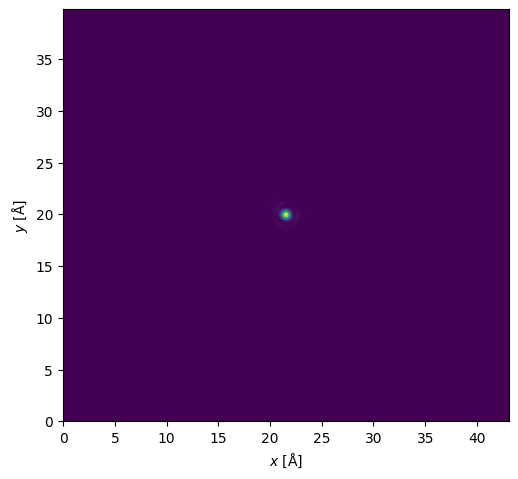

In [9]:
# Probe aberrations (based on Themis), up to 5th order; units are Angstrom & radian
aberrations = {"C10":   22,     # Defocus (C1)
               "C12":   7,      # 2-fold stig (A1)
               "phi12": 2.71,   # 2-fold stig angle
               "C21":   335,    # Coma (B2)
               "phi21": 2.67,   # Coma angle
               "C23":   480,    # 3-fold stig (A2)
               "phi23": 0,      # 3-fold stig angle
               "C30":   -5200,  # Spherical aber (C3 / CS)
               "C32":   7600,   # "Star" aber (S3)
               "phi32": -0.37,  # Star aber angle
               "C34":   3900,   # 4-fold stig (A3)
               "phi34": -1.71,  # 4-fold stig angle
               "C41":   8.4e4,  # 4th order coma (B4)
               "phi41": -0.24,  # 4th order coma angle
               "C43":   1.4e5,  # Three-lobe aber (D4)
               "phi43": 1.40,   # Three-lobe aber angle
               "C45":   1.1e4,  # 5-fold stig (A4)
               "phi45": 1.40,   # 5-fold stig angle
               "C50":   -8e6,   # 5th order spherical aber (C5)
               "C52":   9.7e5,  # 5th order star aber (S5)
               "phi52": 2.04,   # 5th order star aber angle
               "C54":   3.2e5,  # Rosette aber (R5)
               "phi54": -2.09,  # Rosette aber angle
               "C56":   2.8e6,  # 6-fold stig (A5)
               "phi56": 0.98    # 6-fold stig angle
               }

# View probe and verify profile before simulating
# Adding these aberrations has little effect on the FWHM, but changes the tails and reduces the max intensity slightly
abtem.Probe(semiangle_cutoff=17.9, energy=200e3, aberrations=aberrations).match_grid(potential).show()

In [ ]:
# TODO: Simulation seems to hang/crash using PRISM, no explanation as to why...

fpath = tk_popover(save=True)  # Setup filename before running the simulation, so we can save automatically
result = simulate_stem(potential=potential, detectors=detector, convergence=17.9, aberrations=aberrations, eager=True)
result.to_tiff(fpath)
preview_stem_result(result)

Simulating...
[#################################       ] | 84% Completed | 23hr 44m

# Analysis - Simulation

In [163]:
import tifffile
import json
import SingleOrigin as so
from matplotlib import pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, Colormap, to_rgba, to_rgb
from contextlib import contextmanager
from os import devnull
import sys
import copy
import scipy

In [164]:
@contextmanager
def suppress_stdout():  # SingleOrigin prints to stdout a lot, this keeps things a bit tidier
    """Context manager to suppress printing to stdout by piping into devnull; by Dave Smith:
    https://thesmithfam.org/blog/2012/10/25/temporarily-suppress-console-output-in-python/"""
    with open(devnull, "w") as dn:
        old_stdout = sys.stdout
        sys.stdout = dn
        try:
            yield
        finally:
            sys.stdout = old_stdout

In [165]:
def minmax_norm(img):
    """Normalize a 2D array into the range [0, 1]"""
    # Underscores avoid overwriting reserved names
    _min, _max = np.min(img), np.max(img)
    return (img - _min) / (_max - _min)

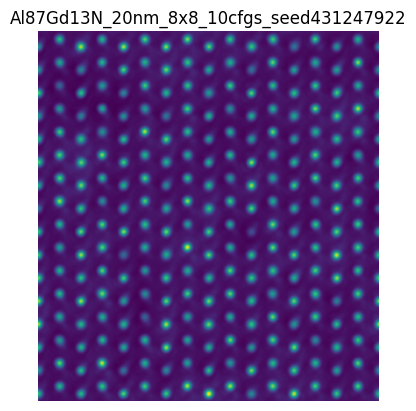

In [188]:
img_path = tk_popover(title="Select image...")
with tifffile.TiffFile(img_path) as tif:
    metadata = json.loads(tif.pages[0].tags["ImageDescription"].value)
img_raw = tifffile.imread(img_path)

# Cast to abTEM format for simple Fourier upscale (4x)
# Sampling is the Nyquist sampling for the probe used in the sim (saved in the .tif metadata)
sampling = metadata["axes"]["axis_0"]["sampling"]  # This assumes the sampling is the same on both axes (usually true)
img_abtem_format = abtem.measurements.Images(array=img_raw, sampling=(sampling, sampling))
img_interp = img_abtem_format.interpolate(sampling=(sampling/4, sampling/4))

# Cast to HRImage (SingleOrigin) format for further analysis
hrimg = so.HRImage(image=minmax_norm(img_interp.array))

# Preview
plt.imshow(hrimg.image)
plt.title(Path(img_path).stem)
plt.axis("off")
plt.show()

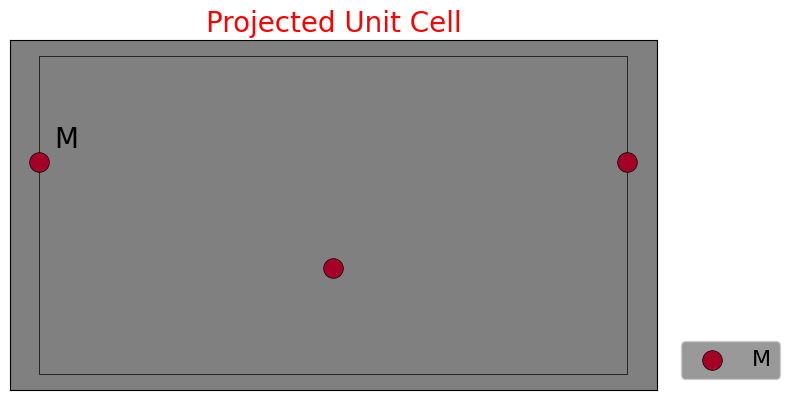

In [189]:
uc = so.UnitCell(path=tk_popover(), origin_shift=(0, 0, 0))
uc.atoms.replace("Al", "M", inplace=True)
with suppress_stdout():
    uc.project_zone_axis((1, 1, 0),  # Zone axis direction
                         (0, 0, 1),  # Apparent horizontal axis in projection
                         (1, -1, 0),  # Most vertical axis in projection
                         ignore_elements=["N"],
                         reduce_proj_cell=True)
    uc.combine_prox_cols(toler=1e-2)
uc.plot_unit_cell()
lattice = hrimg.add_lattice("AlGdN", uc, origin_atom_column=None)















  0%|          | 0/240 [00:00<?, ?it/s]C:\Users\charles\Documents\GitHub\venv_gh\Lib\site-packages\joblib\externals\loky\process_executor.py:1076: UserWarning: On Windows, max_workers cannot exceed 61 due to limitations of the operating system.
  warnings.warn(














 27%|██▋       | 64/240 [00:00<00:01, 140.05it/s]













 53%|█████▎    | 128/240 [00:04<00:04, 25.36it/s]













100%|██████████| 240/240 [00:04<00:00, 48.42it/s]


0.08639360019340411


(<Figure size 1300x1000 with 1 Axes>,
 <Axes: title={'center': 'Warning: scalebar length is based on the pixel size estimated from the reference lattice. The user should specify the calibrated pixel size if known.'}>)

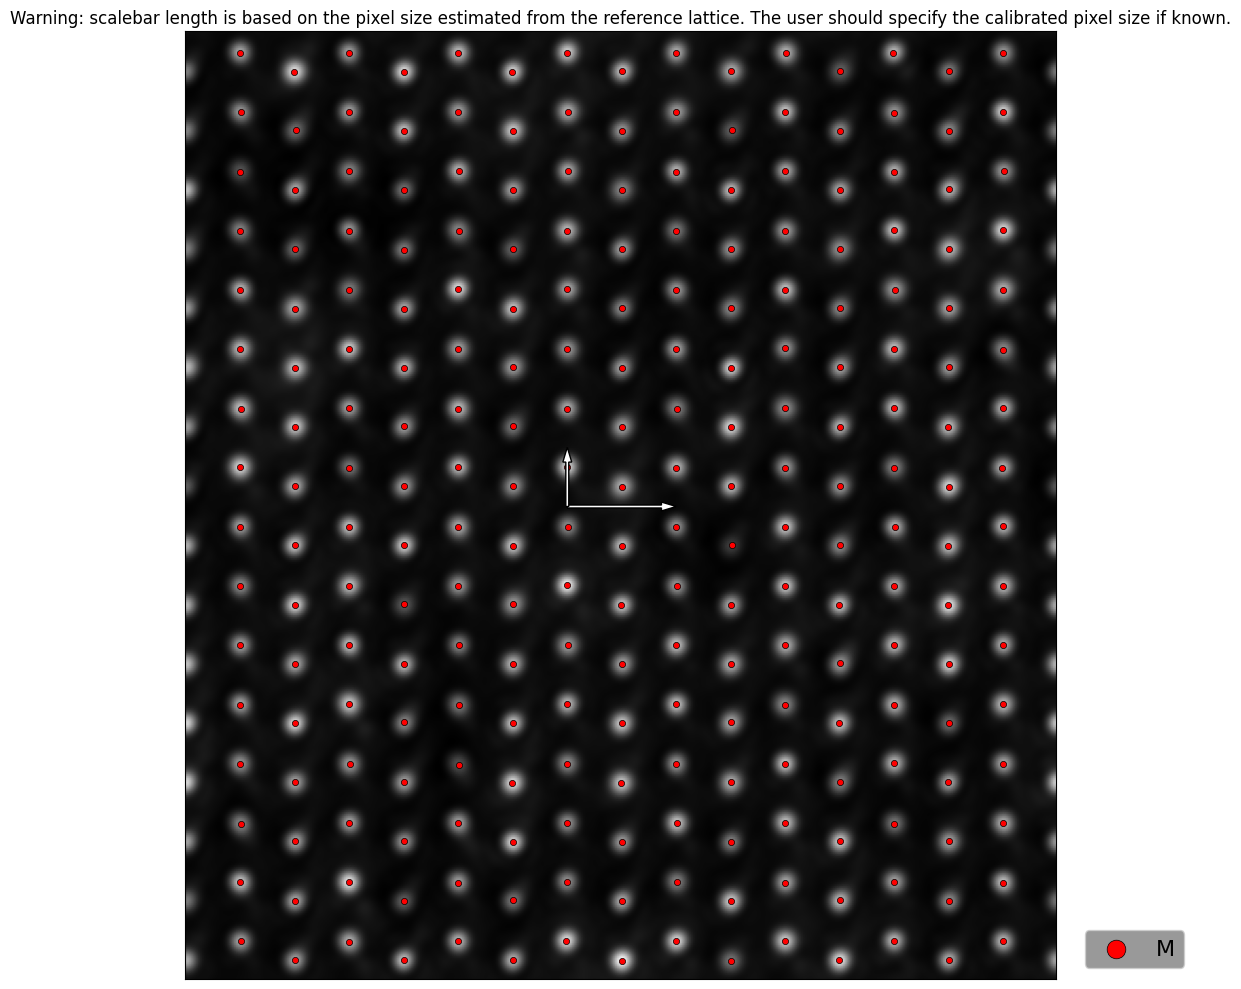

In [191]:
%matplotlib tk
with suppress_stdout():
    lattice.fft_get_basis_vect(a1_order=2,  # Order of peak corresponding to planes in the most horizontal direction
                               a2_order=3,  # Order of peak corresponding to planes in the most vertical direction
                               thresh_factor=0)  # Decrease to detect more peaks
    lattice.define_reference_lattice()

    lattice.fit_atom_columns(buffer=2,
                             bkgd_thresh_factor=0,
                             use_bounds=True,
                             pos_bound_dist=0.3,
                             use_circ_gauss=False,
                             parallelize=True,
                             peak_grouping_filter=None,
                             peak_sharpening_filter="auto")
    lattice.refine_reference_lattice(filter_by="elem",
                                     sites_to_use="M")
%matplotlib inline
hrimg.plot_atom_column_positions(scatter_kwargs_dict={"s": 20}, scalebar_len_nm=None, fit_or_ref="fit")

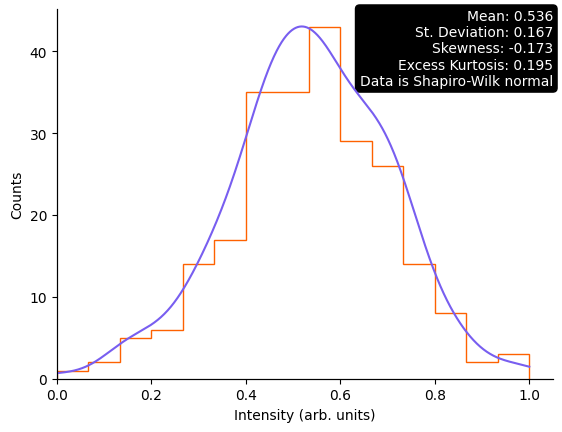

In [192]:
frame = copy.deepcopy(hrimg.latt_dict["AlGdN"].at_cols)
intensities = minmax_norm(np.array(frame["total_col_int"]))
summary_stats = scipy.stats.describe(intensities)

int_kernel = scipy.stats.gaussian_kde(intensities)
density_estimate = int_kernel.evaluate(np.linspace(summary_stats.minmax[0],
                                                   summary_stats.minmax[1],
                                                   1000))

fig, hax = plt.subplots()
kdeax = hax.twinx()
hax.hist(intensities, bins="auto", histtype="step", color="#fe6100")
hax.set_ylabel("Counts")
hax.set_xlabel("Intensity (arb. units)")
kdeax.plot(np.linspace(summary_stats.minmax[0], summary_stats.minmax[1], 1000),
           density_estimate, "-", c="#785ef0")
kdeax.set_yticks([])
kdeax.set_ylim(bottom=0)
hax.set_xlim(summary_stats.minmax[0]*0.95, summary_stats.minmax[1]*1.05)
hax.spines[["right", "top"]].set_visible(False)
kdeax.spines[["right", "top"]].set_visible(False)

# noinspection PyUnresolvedReferences
statstr = (f"Mean: {summary_stats.mean:.3g}\n"
           f"St. Deviation: {np.sqrt(summary_stats.variance):.3g}\n"
           f"Skewness: {summary_stats.skewness:.3g}\n"
           f"Excess Kurtosis: {summary_stats.kurtosis:.3g}\n"
           f"Data is{' not' if scipy.stats.shapiro(intensities)[1]<0.05 else ''} Shapiro-Wilk normal")
hax.text(1, 1, statstr, transform=hax.transAxes, verticalalignment="top", horizontalalignment="right",
         color="white", bbox={"boxstyle": "round", "facecolor": "black"})
plt.show()

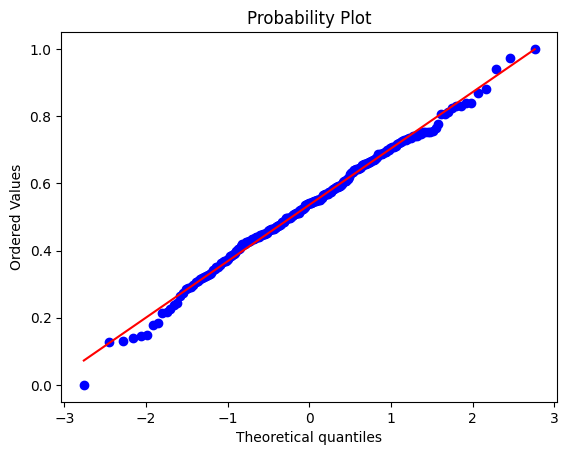

In [193]:
qq = scipy.stats.probplot(intensities, plot=plt)

# Analysis - Experimental

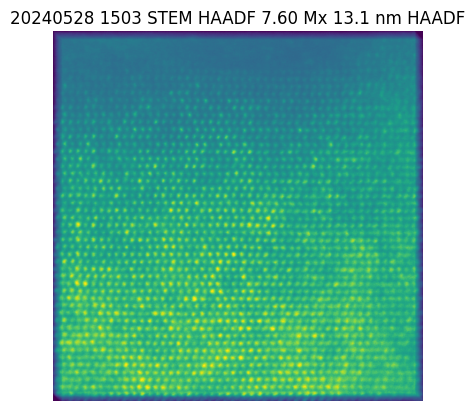

In [176]:
img_path = tk_popover(title="Select image...")
img_raw = tifffile.imread(img_path)

# Cast to HRImage (SingleOrigin) format for further analysis
hrimg = so.HRImage(image=minmax_norm(img_raw))

# Preview
plt.imshow(hrimg.image)
plt.title(Path(img_path).stem)
plt.axis("off")
plt.show()

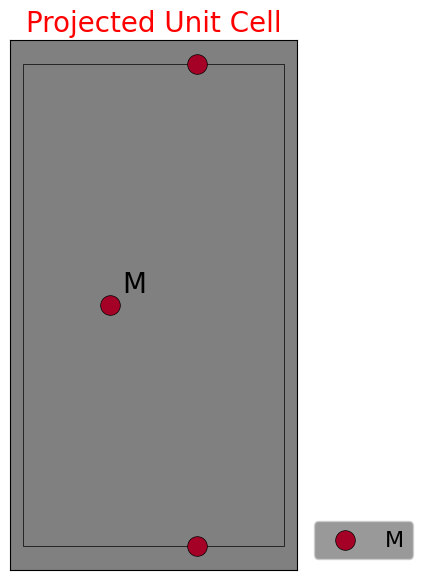

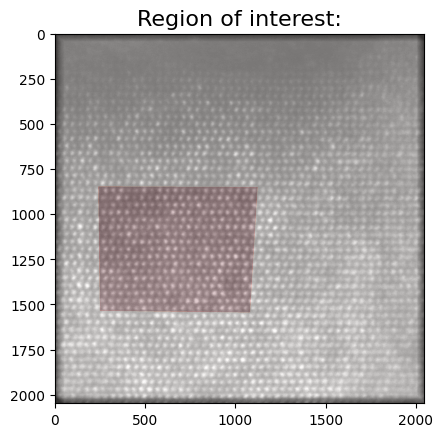

In [177]:
uc = so.UnitCell(path=tk_popover(), origin_shift=(0, 0, 0))
uc.atoms.replace("Al", "M", inplace=True)
with suppress_stdout():
    uc.project_zone_axis((1, 1, 0),  # Zone axis direction
                         (1, -1, 0),  # Apparent horizontal axis in projection
                         (0, 0, 1),  # Most vertical axis in projection
                         ignore_elements=["N"],
                         reduce_proj_cell=True)
    uc.combine_prox_cols(toler=1e-2)
uc.plot_unit_cell()

lattice = hrimg.add_lattice("AlGdN", uc, origin_atom_column=None)
%matplotlib tk
# Selecting a reduced area to try to avoid thickness & mistilt effects
lattice.get_roi_mask_polygon()
%matplotlib inline














  0%|          | 0/309 [00:00<?, ?it/s]C:\Users\charles\Documents\GitHub\venv_gh\Lib\site-packages\joblib\externals\loky\process_executor.py:1076: UserWarning: On Windows, max_workers cannot exceed 61 due to limitations of the operating system.
  warnings.warn(













 21%|██        | 64/309 [00:00<00:01, 141.74it/s]












 41%|████▏     | 128/309 [00:03<00:06, 28.62it/s]












 62%|██████▏   | 192/309 [00:04<00:02, 42.74it/s]












100%|██████████| 309/309 [00:04<00:00, 65.09it/s]


0.06170146533077567


(<Figure size 1300x1000 with 1 Axes>,
 <Axes: title={'center': 'Warning: scalebar length is based on the pixel size estimated from the reference lattice. The user should specify the calibrated pixel size if known.'}>)

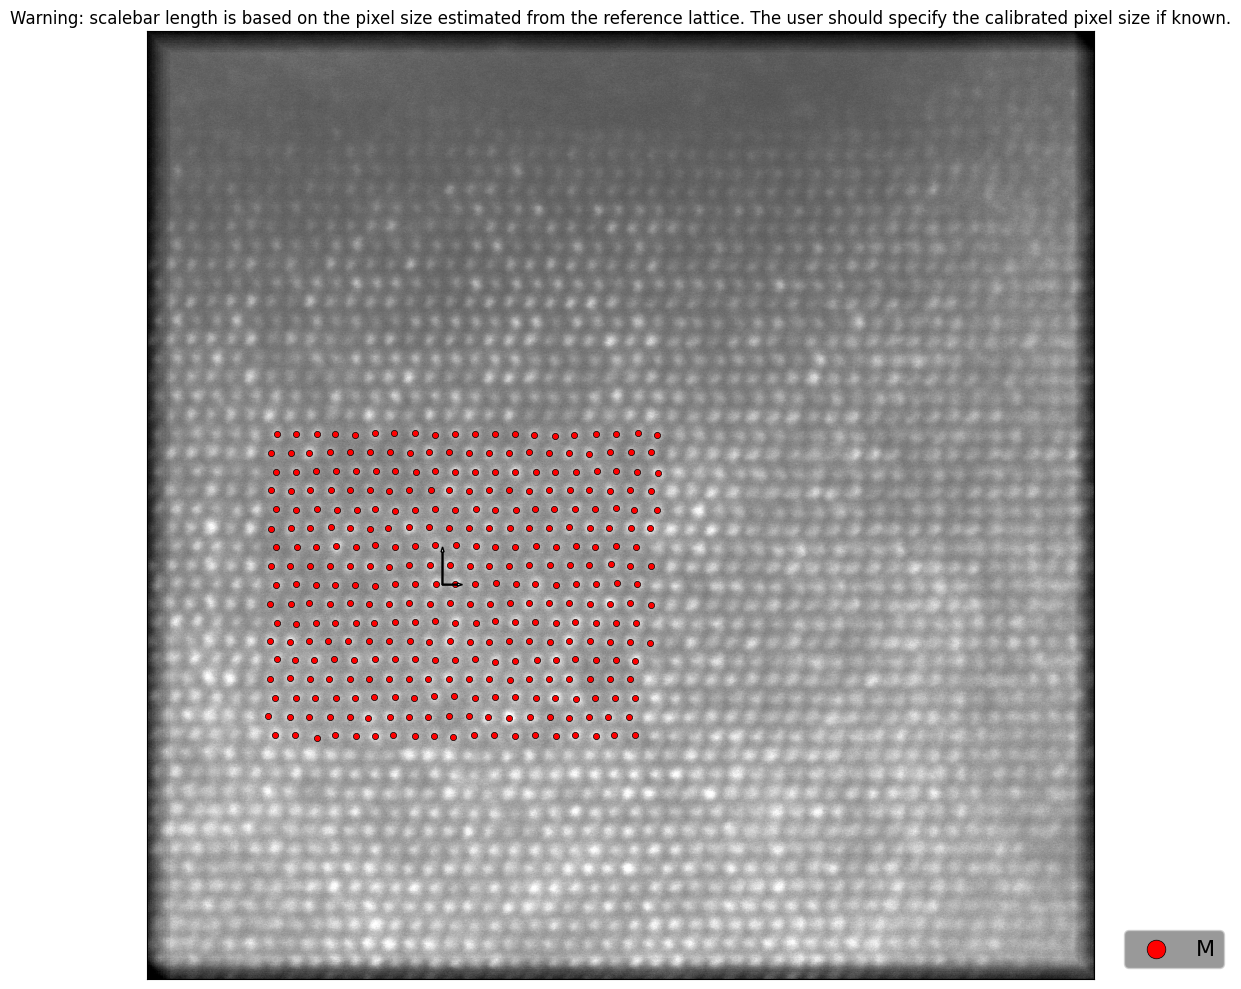

In [179]:
%matplotlib tk
with suppress_stdout():
    lattice.fft_get_basis_vect(a1_order=1,  # Order of peak corresponding to planes in the most horizontal direction
                               a2_order=2,  # Order of peak corresponding to planes in the most vertical direction
                               thresh_factor=0.5)  # Decrease to detect more peaks
    lattice.define_reference_lattice()

    lattice.fit_atom_columns(buffer=2,
                             bkgd_thresh_factor=0,
                             use_bounds=True,
                             pos_bound_dist=0.3,
                             use_circ_gauss=False,
                             parallelize=True,
                             peak_grouping_filter=None,
                             peak_sharpening_filter="auto")
    lattice.refine_reference_lattice(filter_by="elem",
                                     sites_to_use="M")
%matplotlib inline
hrimg.plot_atom_column_positions(scatter_kwargs_dict={"s": 20}, scalebar_len_nm=None, fit_or_ref="fit")

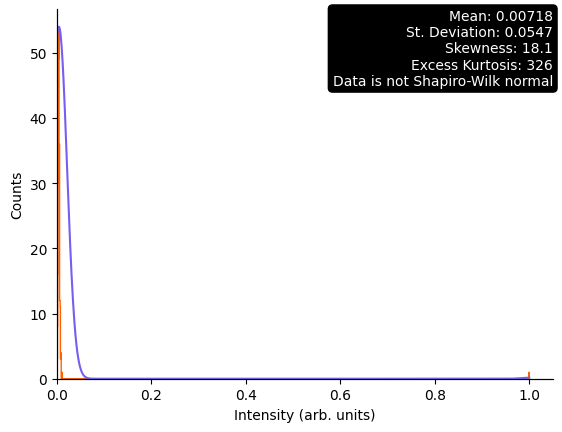

In [180]:
frame = copy.deepcopy(hrimg.latt_dict["AlGdN"].at_cols)
intensities = minmax_norm(np.array(frame["total_col_int"]))
summary_stats = scipy.stats.describe(intensities)

int_kernel = scipy.stats.gaussian_kde(intensities)
density_estimate = int_kernel.evaluate(np.linspace(summary_stats.minmax[0],
                                                   summary_stats.minmax[1],
                                                   1000))

fig, hax = plt.subplots()
kdeax = hax.twinx()
hax.hist(intensities, bins="auto", histtype="step", color="#fe6100")
hax.set_ylabel("Counts")
hax.set_xlabel("Intensity (arb. units)")
kdeax.plot(np.linspace(summary_stats.minmax[0], summary_stats.minmax[1], 1000),
           density_estimate, "-", c="#785ef0")
kdeax.set_yticks([])
kdeax.set_ylim(bottom=0)
hax.set_xlim(summary_stats.minmax[0]*0.95, summary_stats.minmax[1]*1.05)
hax.spines[["right", "top"]].set_visible(False)
kdeax.spines[["right", "top"]].set_visible(False)

# noinspection PyUnresolvedReferences
statstr = (f"Mean: {summary_stats.mean:.3g}\n"
           f"St. Deviation: {np.sqrt(summary_stats.variance):.3g}\n"
           f"Skewness: {summary_stats.skewness:.3g}\n"
           f"Excess Kurtosis: {summary_stats.kurtosis:.3g}\n"
           f"Data is{' not' if scipy.stats.shapiro(intensities)[1]<0.05 else ''} Shapiro-Wilk normal")
hax.text(1, 1, statstr, transform=hax.transAxes, verticalalignment="top", horizontalalignment="right",
         color="white", bbox={"boxstyle": "round", "facecolor": "black"})
plt.show()

We can also see what this distribution looks like with extreme (4$\sigma$) outliers removed

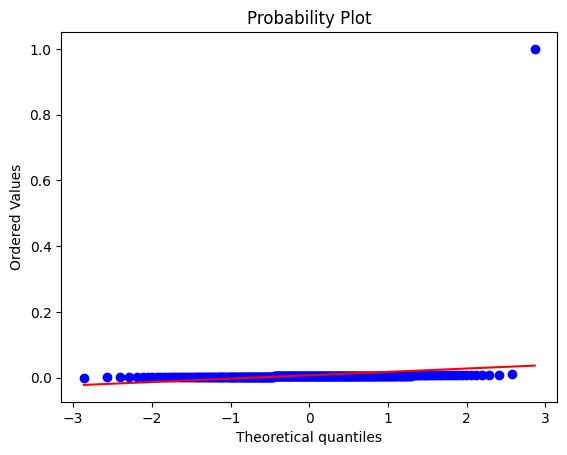

In [187]:
qq = scipy.stats.probplot(intensities, plot=plt)

In [182]:
outlier_thresh = (max(0, summary_stats.mean - 4*np.sqrt(summary_stats.variance)),
                  min(1, summary_stats.mean + 4*np.sqrt(summary_stats.variance)))
ints_filtered = [i for i in intensities if outlier_thresh[0] < i < outlier_thresh[1]]  # Filter outliers
ints_filtered = minmax_norm(np.array(ints_filtered))  # Re-norm w/o outliers
summary_stats_filtered = scipy.stats.describe(ints_filtered)  # Re-calculate stats

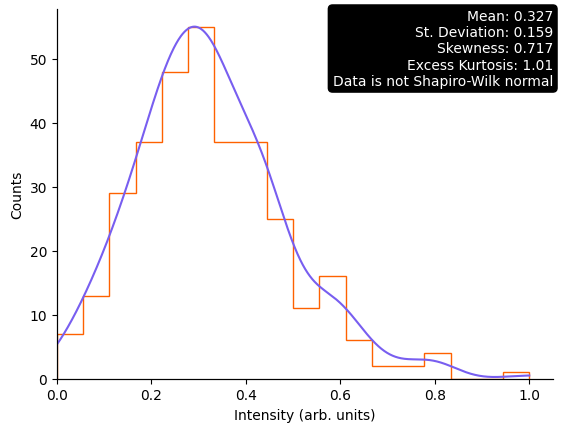

In [183]:
int_kernel = scipy.stats.gaussian_kde(ints_filtered)
density_estimate = int_kernel.evaluate(np.linspace(summary_stats_filtered.minmax[0],
                                                   summary_stats_filtered.minmax[1],
                                                   1000))

fig, hax = plt.subplots()
kdeax = hax.twinx()
hax.hist(ints_filtered, bins="auto", histtype="step", color="#fe6100")
hax.set_ylabel("Counts")
hax.set_xlabel("Intensity (arb. units)")
kdeax.plot(np.linspace(summary_stats_filtered.minmax[0], summary_stats_filtered.minmax[1], 1000),
           density_estimate, "-", c="#785ef0")
kdeax.set_yticks([])
kdeax.set_ylim(bottom=0)
hax.set_xlim(summary_stats_filtered.minmax[0]*0.95, summary_stats_filtered.minmax[1]*1.05)
hax.spines[["right", "top"]].set_visible(False)
kdeax.spines[["right", "top"]].set_visible(False)

# noinspection PyUnresolvedReferences
statstr = (f"Mean: {summary_stats_filtered.mean:.3g}\n"
           f"St. Deviation: {np.sqrt(summary_stats_filtered.variance):.3g}\n"
           f"Skewness: {summary_stats_filtered.skewness:.3g}\n"
           f"Excess Kurtosis: {summary_stats_filtered.kurtosis:.3g}\n"
           f"Data is{' not' if scipy.stats.shapiro(intensities)[1]<0.05 else ''} Shapiro-Wilk normal")
hax.text(1, 1, statstr, transform=hax.transAxes, verticalalignment="top", horizontalalignment="right",
         color="white", bbox={"boxstyle": "round", "facecolor": "black"})
plt.show()

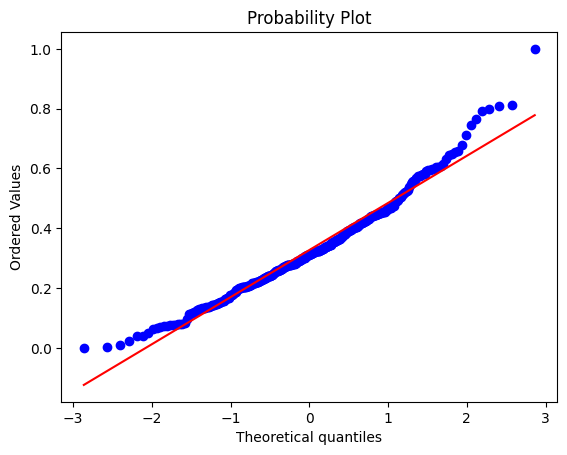

In [185]:
qq = scipy.stats.probplot(ints_filtered, plot=plt)